# Red Neuronal para discriminacion de Gamma/Neutron

Se creara una red neuronal que discrimine entre Gamma y Neutrones a partir de sus trazas de evento, esto a traves de Machine Learning implementado en la FPGA

---

## Entrenamiento
Este entrenamiento se realizará basado en el trabajo previo:
- Workflow based on R. S. Molina, I. R. Morales, M. L. Crespo, V. G. Costa, S. Carrato and G. Ramponi, "An End-to-End Workflow to Efficiently Compress and Deploy DNN Classifiers on SoC/FPGA", in IEEE Embedded Systems Letters, vol. 16, no. 3, pp. 255-258, Sept. 2024, doi: 10.1109/LES.2023.3343030.
- Code adapted from the official repository of "An End-to-End Workflow to Efficiently Compress and Deploy DNN Classifiers on SoC/FPGA"
- Using open dataset from: https://doi.org/10.5281/zenodo.8037058


### Importación de librerias

In [1]:
import os
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

# Tensorflow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2, l1

import tensorflow_model_optimization as tfmot

# Pruning API
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_schedule, pruning_callbacks
from tensorflow_model_optimization.sparsity.keras import strip_pruning

# Quantization API
from qkeras import *

# Knowledge Distillation
from src.distillationClassKeras import *

# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle

# Pre-processing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

# Training utils
from sklearn.model_selection import train_test_split

tf.random.set_seed(42)
np.random.seed(42)


Evaluamos el numero de GPUs disponibles para entrenamiento

In [2]:
# import tensorflow as tf 
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs Available: ", len(physical_devices))
print("Available devices: ", physical_devices)

# for device in physical_devices:
#     tf.config.experimental.set_memory_growth(device, True)

Num GPUs Available:  0
Available devices:  []


### Funciones auxiliares

Definicion de funciones auxiliares para el preprocesamiento del dataset y separacion del set de datos en entrenamiento y test

In [3]:
# Function to define the training and testing datasets

def preproc_dataset_(signal_dfN, signal_dfG):
    # data for Neutrons and Gammas
    # Label in csv file corresponds to the signal class (0: gamma, 1: neutron)
    _LABEL_COLUMN = 'class' 

    dfTest  = pd.DataFrame()
    dfTrain = pd.DataFrame()

    signal_dfN = shuffle(signal_dfN)
    signal_dfG = shuffle(signal_dfG)

    signal_df = pd.concat([signal_dfN, signal_dfG])

    for k in range(0,2):
        df2 = signal_df[signal_df[_LABEL_COLUMN].isin([k])]

        df_tr = df2[:10000]
        df_t  = df2[10001:10900]

        dfTrain = pd.concat([df_tr, dfTrain])
        dfTest  = pd.concat([df_t, dfTest])

    return dfTrain, dfTest


## Dataset

Aqui se carga y se construye el dataset

In [4]:
# Define paths to datasets

PATH = 'dataset/'

GAMMA_DATASET_FILE   = PATH + 'gamma_label.csv'
NEUTRON_DATASET_FILE = PATH + 'neutron_label.csv'

TEST_DATASET_FILE  = PATH + 'test.csv'

# Load datasets
dfGamma   = pd.read_csv(GAMMA_DATASET_FILE)
dfNeutron = pd.read_csv(NEUTRON_DATASET_FILE)
dfTestGN  = pd.read_csv(TEST_DATASET_FILE)

Visualizacion de los datos

Gamma dataset shape:  (10913, 162)
Neutron dataset shape:  (27696, 162)
Test dataset shape:  (1798, 162)


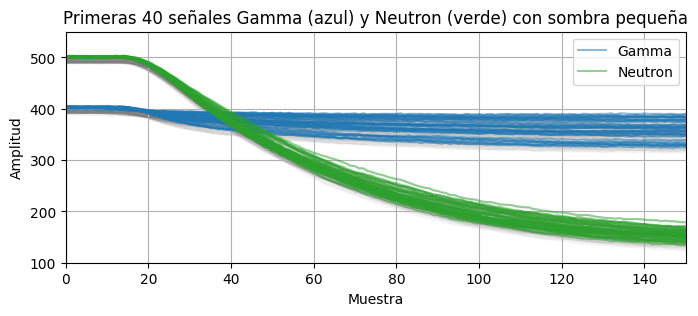

In [5]:
# Explore datasets and plot some signals
print("Gamma dataset shape: ", dfGamma.shape)
print("Neutron dataset shape: ", dfNeutron.shape)
print("Test dataset shape: ", dfTestGN.shape)
dfGamma.head()
dfNeutron.head()
dfTestGN.head()

plt.figure(figsize=(8, 3))

# Graficar 40 señales gamma en azul con sombra pequeña debajo de la línea
for i in range(40):
    y = dfGamma.iloc[i, :-1]
    x = range(len(y))
    plt.plot(x, y, color='tab:blue', alpha=0.5, label='Gamma' if i == 0 else "")
    plt.fill_between(x, y, y-10, color='tab:gray', alpha=0.05)  # Sombra pequeña

# Graficar 40 señales neutron en verde con sombra pequeña debajo de la línea
for i in range(40):
    y = dfNeutron.iloc[i, :-1]
    x = range(len(y))
    plt.plot(x, y, color='tab:green', alpha=0.5, label='Neutron' if i == 0 else "")
    plt.fill_between(x, y, y-10, color='tab:gray', alpha=0.05)  # Sombra pequeña

plt.title("Primeras 40 señales Gamma (azul) y Neutron (verde) con sombra pequeña")
plt.xlabel("Muestra")
plt.ylabel("Amplitud")
plt.xlim(0, 150)
plt.ylim(100, 550)
plt.legend()
plt.grid()
plt.show()

### Preprocesamiento y separacion de dataset

Separacion del dataset en datos de entrenamiento y de test

In [6]:
# Pre-processing dataset for training
df_train, dfTest = preproc_dataset_(dfNeutron, dfGamma)

# Save the test
# dfTest.to_csv('dataset/test.csv')

df_train_ = df_train.pop('class')
dfTest_   = dfTest.pop('class')

# One-hot encoder
le = LabelEncoder()
y = le.fit_transform(df_train_)
y = to_categorical(df_train_, 2)

le = LabelEncoder()
yTest = le.fit_transform(dfTest_)
yTest = to_categorical(dfTest_, 2)

# Split training dataset into training and validation
x_train, x_val, y_train, y_val = train_test_split(df_train, y, test_size=0.3, random_state=42)


## Machine learning - Training and compression

**Poda (Pruning)**:
Es una técnica para reducir el tamaño y la complejidad de un modelo eliminando pesos o neuronas que no aportan mucho. Su objetivo es hacerlo más eficiente, con menor uso de memoria y mayor velocidad de inferencia, sin perder demasiada precisión.

**Cuantización (Quantization)**:
Consiste en bajar la precisión numérica de los parámetros (por ejemplo, de 32 bits a 16 u 8 bits). Esto reduce el tamaño del modelo y acelera la inferencia, especialmente útil en dispositivos con recursos limitados como móviles o microcontroladores.

**Entrenamiento con reconocimiento de cuantización (QAT)**:
Es una técnica de entrenamiento donde el modelo aprende a adaptarse a la cuantización antes de desplegarse en hardware. En lugar de entrenarlo en precisión completa (32 bits) y después cuantizarlo, la cuantización se introduce durante el entrenamiento.

**Poda con reconocimiento de cuantización (QAP)**:
Combina la poda (eliminación de conexiones innecesarias en la red) con el entrenamiento consciente de la cuantización. El objetivo es reducir el tamaño del modelo antes de cuantizarlo para obtener una red más eficiente sin perder precisión.

---

### Destilación de conocimiento

Para obtener el modelo reducido que se desplegará en la FPGA (denominado en adelante estudiante), se empleará el enfoque de aprendizaje llamado **destilación de conocimiento (knowledge distillation, KD)**. Este método consiste en que un modelo maestro (teacher) transfiere su conocimiento al modelo estudiante, de forma que este último aprende a imitar el comportamiento del primero, pero con menor complejidad.

Para más información sobre KD:
Hinton, G. (2015). Distilling the Knowledge in a Neural Network. arXiv preprint arXiv:1503.02531.

## Teacher training

In [7]:
# Define the hyperparameters for the teacher model

lr = 0.0001
neurons_teacher = [10, 5, 7, 5, 6]

La siguiente funcion define la arquitectura del **teacher** compuesto por seis capas densas, *bestHP* contiene el numero de neuronas por cada capa densa

In [8]:
def teacher_topology(bestHp):

    teacher = keras.Sequential(
        [
            keras.Input(shape=(161, )),
            Dense(bestHp[0], name='fc1', input_shape=(161,), kernel_regularizer=l2(0.001),),
            Activation(activation='relu', name='relu1'),

            Dense(bestHp[1], name='fc2', kernel_regularizer=l2(0.001),),
            Activation(activation='relu', name='relu2'),

            Dense(bestHp[2], name='fc3', kernel_regularizer=l2(0.001),),
            Activation(activation='relu', name='relu3'),
            Dropout(0.1),

            Dense(bestHp[3], name='fc4', kernel_regularizer=l2(0.001),),
            Activation(activation='relu', name='relu4'),
            Dropout(0.2),

            Dense(bestHp[4], name='fc5'),
            Activation(activation='relu', name='relu5'),
            Dropout(0.2),

            Dense(2, name='output'),
            Activation(activation='sigmoid', name='activationOutput'),
        ],
        name='teacher_MLP',
    )

    teacher.summary()

    return teacher

### Construccion del modelo Teacher

Esta función define la topología del modelo maestro llamando a la función ´teacher_topology()´, configura el optimizador **Adam** con la tasa de aprendizaje correspondiente y establece la configuración del modelo utilizando binary_crossentropy como función de pérdida y accuracy como métrica de evaluación.

In [9]:
def build_teacher(neurons_teacher):
    model = teacher_topology(neurons_teacher)
    opt = Adam(lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [10]:
teacher_model = build_teacher(neurons_teacher)

Model: "teacher_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 10)                1620      
                                                                 
 relu1 (Activation)          (None, 10)                0         
                                                                 
 fc2 (Dense)                 (None, 5)                 55        
                                                                 
 relu2 (Activation)          (None, 5)                 0         
                                                                 
 fc3 (Dense)                 (None, 7)                 42        
                                                                 
 relu3 (Activation)          (None, 7)                 0         
                                                                 
 dropout (Dropout)           (None, 7)                 

## Training

Entrenamiento del modelo teacher

In [11]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        verbose=1,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.4,
        patience=3,
        verbose=1
    )
]

history_teacher = teacher_model.fit(
    x=x_train, y=y_train,
    validation_data=(x_val, y_val),
    batch_size=64,
    epochs=100,
    callbacks=callbacks,   
    verbose=1
)

Epoch 1/100
219/219 [==============================] - 1s 2ms/step - loss: 1.4643 - accuracy: 0.7580 - val_loss: 0.5125 - val_accuracy: 0.9930 - lr: 1.0000e-04
Epoch 2/100
219/219 [==============================] - 0s 2ms/step - loss: 0.5696 - accuracy: 0.8789 - val_loss: 0.4539 - val_accuracy: 0.9915 - lr: 1.0000e-04
Epoch 3/100
219/219 [==============================] - 0s 2ms/step - loss: 0.5168 - accuracy: 0.9268 - val_loss: 0.3900 - val_accuracy: 0.9927 - lr: 1.0000e-04
Epoch 4/100
219/219 [==============================] - 0s 2ms/step - loss: 0.4858 - accuracy: 0.9369 - val_loss: 0.3791 - val_accuracy: 0.9945 - lr: 1.0000e-04
Epoch 5/100
219/219 [==============================] - 0s 1ms/step - loss: 0.4623 - accuracy: 0.9474 - val_loss: 0.3640 - val_accuracy: 0.9925 - lr: 1.0000e-04
Epoch 6/100
219/219 [==============================] - 0s 1ms/step - loss: 0.4470 - accuracy: 0.9511 - val_loss: 0.3566 - val_accuracy: 0.9945 - lr: 1.0000e-04
Epoch 7/100
219/219 [===================

### Plot accuracy and loss

Plots el comportamiento de la exactitud y la perdida durante el entrenamiento.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


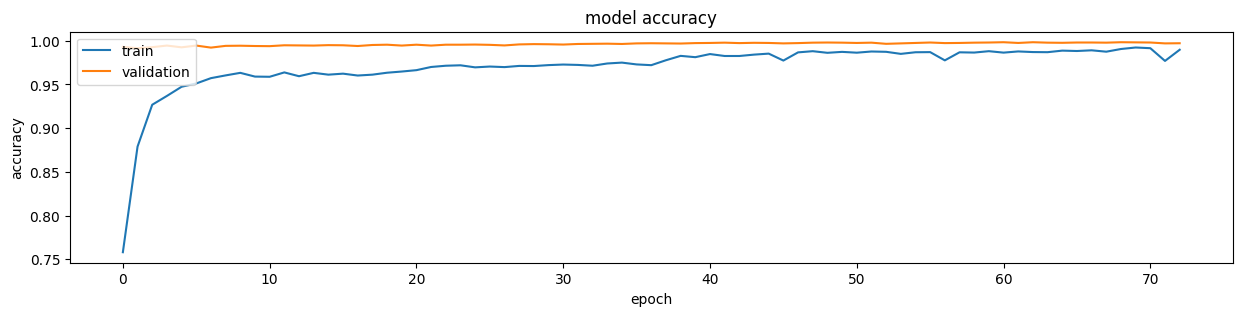

<Figure size 640x480 with 0 Axes>

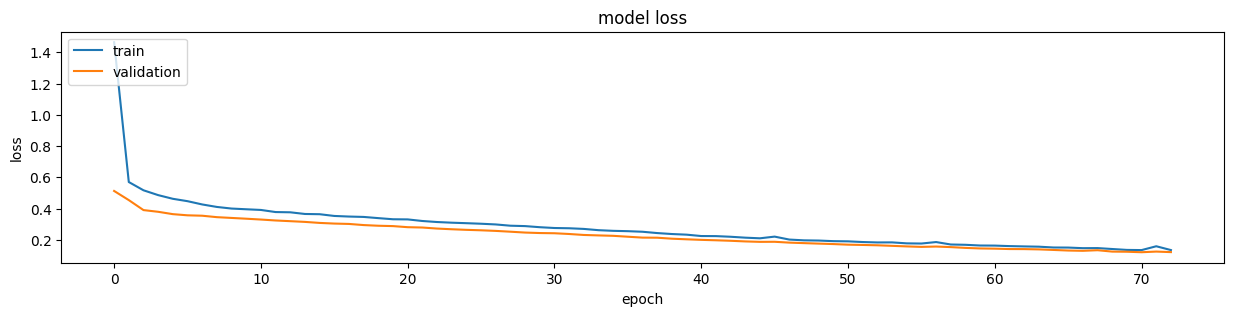

In [12]:
print(history_teacher.history.keys())

## Plot for accuracy
plt.figure(figsize=(15,3))
plt.plot(history_teacher.history['accuracy'])
plt.plot(history_teacher.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.figure()

## Plot for loss
plt.figure(figsize=(15,3))
plt.plot(history_teacher.history['loss'])
plt.plot(history_teacher.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Hasta aqui ya se logró un entrenamiento satisfactorio de la red neuronal

---

## Analisis del rendimiento

Medimos el rendimiento mediante la matriz de confusion

57/57 [==============================] - 0s 644us/step


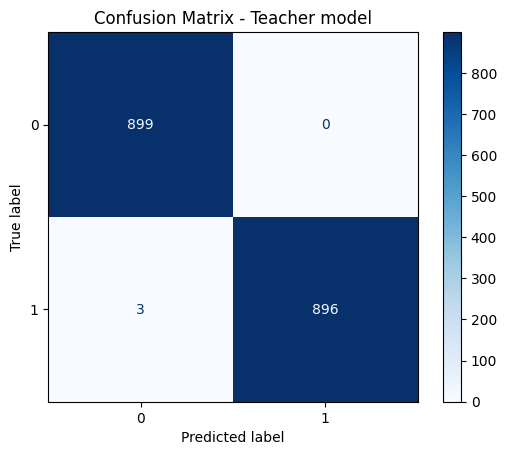

In [13]:
# Obtain the confusion matrix using the testing dataset 
y_pred_probs = teacher_model.predict(dfTest)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(yTest, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
#plt.figure(figsize=(6, 6))
plt.title('Confusion Matrix - Teacher model')
plt.show()

### Analisis de distribucion de pesos

Ahora se evaluara la distribucion de pesos de la red para evaluar cuales son menos significativos

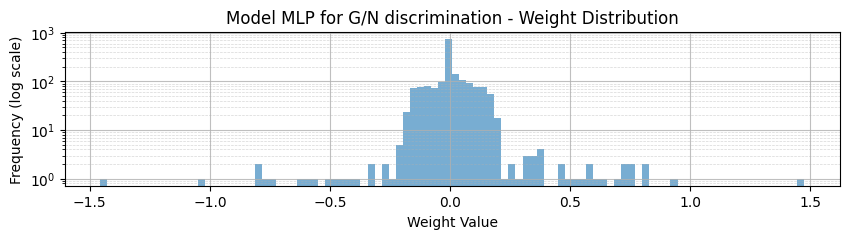

In [14]:
# Weight distribution

weights = np.concatenate([w.flatten() for w in teacher_model.get_weights()])

plt.figure(figsize=(10,2))
plt.hist(weights, bins=100, color='tab:blue', alpha=0.6)
plt.xlabel("Weight Value")
plt.ylabel("Frequency (log scale)")
plt.title("Model MLP for G/N discrimination - Weight Distribution")

# Escala logarítmica en el eje Y
plt.yscale("log")

# Grid principal -> línea continua
plt.grid(which="major", linestyle="-", linewidth=0.8, alpha=0.8)

# Grid secundario -> línea punteada y tenue
plt.grid(which="minor", linestyle="--", linewidth=0.5, alpha=0.5)

plt.show()

### Guardado del modelo Teacher

In [ ]:
# If needed, save the teacher model [uncomment the following line]
# teacher_model.save('models/teacherModel_GN_GICM.h5')

---
**Autor**: Fabian Castaño